# Analysis_AlgoProfileRelevance_ClassWeights
## Block 1: Importing libraries

In [1]:
# Packages / libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Block 2: Data loading

In [2]:
# Load the data (file location to change according to the user)
raw_data = pd.read_csv('C:\\Users\\filip\\Documents\\HSG\\Master\\Master Thesis\\Research\\Data for Python\\Data Analysis AlgoProfileRelevance.csv')

# Run the first 10 rows
raw_data.head(10)

,index,algorithmization,algo_profile
0,67,9,10
1,15,8,9
2,59,8,7
3,9,7,6
4,27,7,10
5,39,7,8
6,13,6,10
7,54,6,7
8,58,6,3
9,83,6,9


## Bock 3: Data cleaning

In [3]:
# Create a copy
data = raw_data.copy(deep=True)

# Drop the index column
data = data.drop(['index'], axis = 1)

# Normalize the explanatory variable
data['algorithmization'] = data['algorithmization'] / 10

# Find a threshold using Leave-One-Out Cross-Validation
loo = LeaveOneOut()
thresholds = []
for train_index, test_index in loo.split(data):
    train_set = data.iloc[train_index]
    test_set = data.iloc[test_index]
    model = LogisticRegression().fit(train_set[['algorithmization']], train_set['algo_profile'])
    predicted = model.predict(test_set[['algorithmization']])
    thresholds.append(predicted[0])

# Convert the explained variable into a binary variable
threshold = np.median(thresholds)
print("\nTreshold for algorithmic profile:", threshold)
data['algo_profile'] = (data['algo_profile'] > threshold).astype(int)

# Run the first 10 rows
data.head(10)


Treshold for algorithmic profile: 3.0


,algorithmization,algo_profile
0,0.9,1
1,0.8,1
2,0.8,1
3,0.7,1
4,0.7,1
5,0.7,1
6,0.6,1
7,0.6,1
8,0.6,0
9,0.6,1


## Block 4: Model training

In [4]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(data[['algorithmization']], data['algo_profile'], test_size=0.2, random_state=42)

# Add a constant term to the independent variable matrix for the logistic regression
X_train_sm = sm.add_constant(X_train)

# Check for balanced train set
value_counts = y_train.value_counts()
num_zeros = value_counts[0]
num_ones = value_counts[1]
print("Train set:")
print("Quantity of y=0:", num_zeros)
print("Quantity of y=1:", num_ones)

Train set:
Quantity of y=0: 15
Quantity of y=1: 26


In [5]:
# Get a balanced set by calculating class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Train the logistic regression model using statsmodels with class weights
logit_model = sm.Logit(y_train, X_train_sm, weight=class_weights[y_train])
result = logit_model.fit()

# Display logistic regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.481366
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           algo_profile   No. Observations:                   41
Model:                          Logit   Df Residuals:                       39
Method:                           MLE   Df Model:                            1
Date:                Fri, 16 Feb 2024   Pseudo R-squ.:                  0.2670
Time:                        23:15:20   Log-Likelihood:                -19.736
converged:                       True   LL-Null:                       -26.925
Covariance Type:            nonrobust   LLR p-value:                 0.0001495
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.6678      0.783     -2.131      0.033      -3.202      -0.134
algorithmiz

## Block 5: Model evaluation

In [6]:
# Get predicted probabilities and class predictions
X_train_sm_test = sm.add_constant(X_train)
y_pred_prob = result.predict(X_train_sm_test)
y_pred_class = (y_pred_prob > 0.5).astype(int)

# Training accuracy
print("\nTraining accuracy: ", (y_pred_class == y_train).mean())

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_pred_class))

print("\nClassification Report:")
print(classification_report(y_train, y_pred_class))


Training accuracy:  0.8292682926829268

Confusion Matrix:
[[10  5]
 [ 2 24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.83      0.92      0.87        26

    accuracy                           0.83        41
   macro avg       0.83      0.79      0.81        41
weighted avg       0.83      0.83      0.82        41



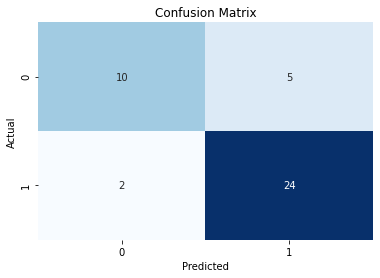

In [7]:
# Calculate and plot the confusion matrix
cm = confusion_matrix(y_train, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Block 6: Model visualization

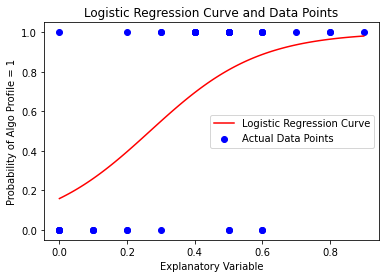

In [8]:
# Conditional probabilities representation

# Create a scatter plot of the data points
plt.scatter(X_train, y_train, color='blue', label='Actual Data Points')

# Overlay the logistic regression curve
X_range = np.linspace(X_train.min(), X_train.max(), 100)
X_range_sm = sm.add_constant(X_range)
y_probabilities = result.predict(X_range_sm)
plt.plot(X_range, y_probabilities, color='red', label='Logistic Regression Curve')

# Customize the plot
plt.xlabel('Explanatory Variable')
plt.ylabel('Probability of Algo Profile = 1')
plt.title('Logistic Regression Curve and Data Points')
plt.legend()

# Show the plot
plt.show()

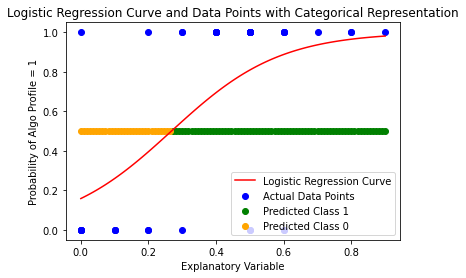

In [9]:
# Categorical representation

# Create a scatter plot of the data points
plt.scatter(X_train, y_train, color='blue', label='Actual Data Points')

# Overlay the logistic regression curve
X_range = np.linspace(X_train.min(), X_train.max(), 100)
X_range_sm = sm.add_constant(X_range)
y_probabilities = result.predict(X_range_sm)
plt.plot(X_range, y_probabilities, color='red', label='Logistic Regression Curve')

# Set the threshold for classification
threshold = 0.5

# Mark points based on the chosen threshold
y_pred_class = (y_probabilities >= threshold).astype(int)
plt.scatter(X_range[y_pred_class == 1], threshold * np.ones_like(X_range)[y_pred_class == 1], color='green', marker='o', label='Predicted Class 1')
plt.scatter(X_range[y_pred_class == 0], threshold * np.ones_like(X_range)[y_pred_class == 0], color='orange', marker='o', label='Predicted Class 0')

# Customize the plot
plt.xlabel('Explanatory Variable')
plt.ylabel('Probability of Algo Profile = 1')
plt.title('Logistic Regression Curve and Data Points with Categorical Representation')
plt.legend()

# Show the plot
plt.show()

## Block 7: Model testing

In [10]:
# Check for balanced test set
value_counts_ = y_test.value_counts()
num_zeros = value_counts_[0]
num_ones = value_counts_[1]
print("Test set:")
print("Quantity of y=0:", num_zeros)
print("Quantity of y=1:", num_ones)

Test set:
Quantity of y=0: 4
Quantity of y=1: 7


In [11]:
# Now, get predicted probabilities and class predictions for the test set
X_test_sm = sm.add_constant(X_test)
y_pred_prob_test = result.predict(X_test_sm)
y_pred_class_test = (y_pred_prob_test > 0.5).astype(int)

# Calculate accuracy for the test set
accuracy_test = np.mean(y_test == y_pred_class_test)
print("\nAccuracy (Test Set):", accuracy_test)

# Confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_class_test))

# Print classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_class_test))


Accuracy (Test Set): 0.8181818181818182

Confusion Matrix:
[[3 1]
 [1 6]]

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.86      0.86      0.86         7

    accuracy                           0.82        11
   macro avg       0.80      0.80      0.80        11
weighted avg       0.82      0.82      0.82        11



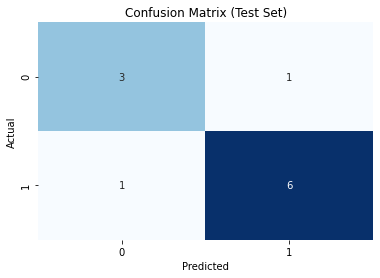

In [12]:
# Calculate and plot the confusion matrix
cm_test = confusion_matrix(y_test, y_pred_class_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()